In [168]:
%matplotlib inline
import numpy as np
import pandas as pd
import lime
import lime.lime_tabular
import shap
import time
import sys
sys.path.append('../../wrapper')
import xgboost
import random

import mglearn
import sklearn
import sklearn.datasets

from sklearn import preprocessing, pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

import matplotlib
import matplotlib.pyplot as plt

In [196]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print ('[%s]' % self.name)
        print ('Elapsed: %s' % (time.time() - self.tstart))

In [349]:
R = np.random.RandomState(0)
df = pd.DataFrame(R.randint(low=1, high=11, size=(10000, 1)), columns=['a'])
df['b'] = R.randint(low=1, high=11, size=(10000, 1))
df['c'] = R.randint(low=1, high=11, size=(10000, 1))
df['d'] = R.randint(low=1, high=11, size=(10000, 1))

df['a*b'] = df.a * df.b
df['a/b'] = df.a / df.b
#df['a*b*c'] = df.a * df.b * df.c

#df['y'] = np.where((df['a*b'] > 60)  , 'True', 'False')
#df['y'] = np.where((df['a*b'] > 60) & (df['b'] > 9) , 'True', 'False')
df['y'] = np.where((df['a*b'] > 55) & (df['c'] > 7) & (df['d'] < 7), 'True', 'False')

for i in range(500):
    df[i+1] = R.randint(low=1, high=11, size=(10000, 1))
#df.plot.box()

In [350]:
#df.describe()

In [351]:
df.groupby('y').count()

,a,b,c,d,a*b,a/b,1,2,3,4,...,491,492,493,494,495,496,497,498,499,500
y,,,,,,,,,,,,,,,,,,,,,
False,9686,9686,9686,9686,9686,9686,9686,9686,9686,9686,...,9686,9686,9686,9686,9686,9686,9686,9686,9686,9686
True,314,314,314,314,314,314,314,314,314,314,...,314,314,314,314,314,314,314,314,314,314


In [352]:
y = df.y
X = df.drop(['y'], 1)
feature_names = df.drop(['y'], 1).columns.values.tolist()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [353]:
le= sklearn.preprocessing.LabelEncoder()
le.fit(y)
labels = le.transform(y)
class_names = le.classes_
target_names = np.array(le.classes_)

In [354]:
rf = RandomForestClassifier(n_estimators=500, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [355]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train, y_train)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9760


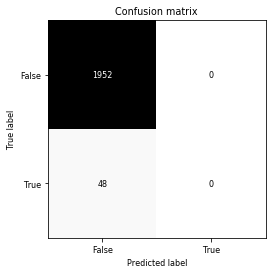

In [356]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### Random under-sampling

In [357]:
print('y_resample:\n{}'.format(pd.Series(y_train).value_counts()))

y_resample:
False    7734
True      266
Name: y, dtype: int64


In [358]:
rus = RandomUnderSampler(random_state=0)
X_train_sampled, y_train_sampled = rus.fit_sample(X_train, y_train)
print('X_resampled.shape: {}, y_resampled: {}'.format(X_train_sampled.shape, y_train_sampled.shape))
print('y_resample:\n{}'.format(pd.Series(y_train_sampled).value_counts()))

X_resampled.shape: (532, 506), y_resampled: (532,)
y_resample:
True     266
False    266
dtype: int64


In [359]:
rf.fit(X_train_sampled, y_train_sampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [360]:
sklearn.metrics.accuracy_score(y_test, rf.predict(X_test))
print('Train score: {:.4f}'.format(rf.score(X_train_sampled, y_train_sampled)))
print('Test score: {:.4f}'.format(rf.score(X_test, y_test)))

Train score: 1.0000
Test score: 0.9245


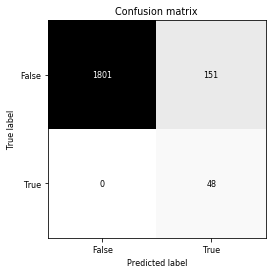

In [361]:
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, rf.predict(X_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [362]:
X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))

### Feature selection

In [365]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=500, random_state=0),
    threshold="2.1*median")
#    threshold="6.7*median")

In [366]:
select.fit(X_train_sampled, y_train_sampled)
#X_train_selected = select.transform(X_train_sampled)
idxs_selected = select.get_support(indices=True)
X_train_selected = X_train_sampled.iloc[:, idxs_selected]

#X_test_selected = select.transform(X_test_sampled)
#idxs_selected = select.get_support(indices=True)
X_test_selected = X_test.iloc[:, idxs_selected]

print("X_train.shape: {}".format(X_train_sampled.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))
print("X_test_selected.shape: {}".format(X_test_selected.shape))

X_train.shape: (532, 506)
X_train_selected.shape: (532, 14)
X_test_selected.shape: (2000, 14)


In [367]:
feature_importances = select.estimator_.feature_importances_[idxs_selected]
idx = sorted(range(len(feature_importances)), key=lambda k: feature_importances[k])

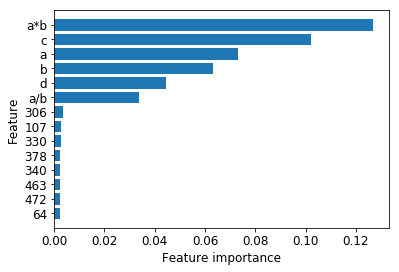

In [507]:
plt.rcParams['savefig.dpi'] = 120 # Use 300 for PDF, 100 for slides
def plot_feature_importances(model):
    n_features = X_train_selected.shape[1]
    plt.barh(range(n_features), sorted(feature_importances), align='center')
    plt.yticks(np.arange(n_features), np.array(list(X_train_selected))[idx])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

    
plt.rcParams.update({'font.size': 12})
plot_feature_importances(select)

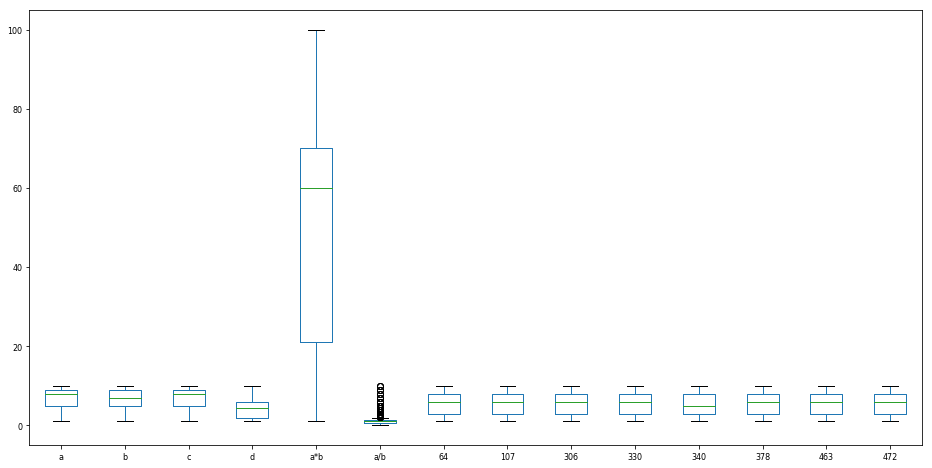

In [369]:
X_train_selected.plot.box(figsize=(16,8))

In [264]:
def classification(classifier):
    model = classifier
    model.fit(X_train_selected, y_train_sampled)
    cv_score = np.mean(cross_val_score(model, X_train_selected, y_train_sampled, cv=5))
    test_score = model.score(X_test_selected, y_test)
    print('Classifier parameters:', model.get_params)
    print("Cross-validation accuracy: {:.3f}".format(cv_score))    
    print('Test score: {:.3f}'.format(test_score))
    return model, cv_score, test_score

In [265]:
def confusion_matrix_plot(model):
    scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_test, model.predict(X_test_selected)), xlabel='Predicted label',
        ylabel='True label', xticklabels=target_names,
        yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
    plt.title("Confusion matrix")
    plt.gca().invert_yaxis()

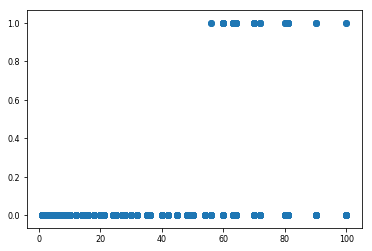

In [266]:
plt.scatter(X_test_selected["a*b"], le.transform(y_test))

In [233]:
pipe = pipeline.Pipeline([('preprocessing', None), ('classifier', SVC())])
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), MinMaxScaler(), None],
     'classifier__kernel': ['rbf', 'linear'],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     {'classifier': [RandomForestClassifier()], 'preprocessing': [StandardScaler(), None],
#      'classifier__n_estimators': [100, 500, 1000],
#      'classifier__bootstrap': [True, False],
#      'classifier__criterion': ['gini', 'entropy']},
]
     
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

grid.fit(X_train_selected, y_train_sampled)
print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test_selected, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.998
Test set score: 0.991
Best parameters: {'preprocessing': None, 'classifier__kernel': 'linear', 'classifier': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__gamma': 0.001, 'classifier__C': 1}


In [478]:
svm_1, cv_score_svm_1, test_score_svm_1 = classification(SVC(gamma=1, probability=True))
svm_2, cv_score_svm_2, test_score_svm_2 = classification(SVC(gamma=0.1, probability=True))
svm_3, cv_score_svm_3, test_score_svm_3 = classification(SVC(gamma=0.01, probability=True))
svm_4, cv_score_svm_4, test_score_svm_4 = classification(SVC(gamma=10, probability=True))

Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.504
Test score: 0.976
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.713
Test score: 0.974
Classifier parameters: <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)>
Cross-validation accuracy: 0.951
Test 

gamma = 10.000  accuracy = 0.463  AUC = 0.964
gamma = 1.000  accuracy = 0.976  AUC = 0.872
gamma = 0.100  accuracy = 0.974  AUC = 0.981
gamma = 0.010  accuracy = 0.938  AUC = 0.992


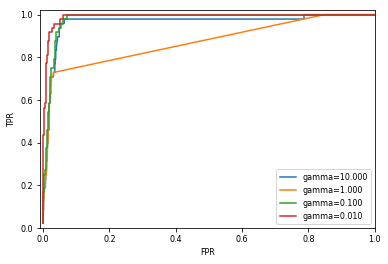

In [482]:
from sklearn.metrics import roc_curve
#fpr1, tpr1, thresholds1 = roc_curve(le.transform(y_test), test1.predict_proba(X_test_selected)[:, 1])

#plt.plot(fpr1, tpr1, label="ROC Curve 1")

for gamma in [10, 1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train_selected, y_train_sampled)
    accuracy = svc.score(X_test_selected, y_test)
    auc = roc_auc_score(le.transform(y_test), svc.decision_function(X_test_selected))
    fpr, tpr, _ = roc_curve(le.transform(y_test), svc.decision_function(X_test_selected))
    print("gamma = {:.3f}  accuracy = {:.3f}  AUC = {:.3f}".format(
            gamma, accuracy, auc))
    plt.plot(fpr, tpr, label="gamma={:.3f}".format(gamma))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

n_estimators = 1  accuracy = 0.969  AUC = 0.953
n_estimators = 2  accuracy = 0.996  AUC = 0.987
n_estimators = 10  accuracy = 0.999  AUC = 1.000


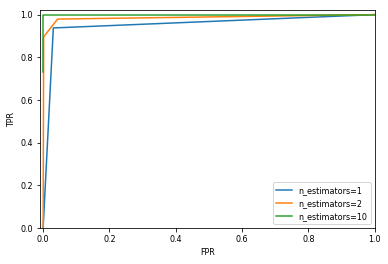

In [498]:
for n_estimators in [1, 2, 10]:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0).fit(X_train_selected, y_train_sampled)
    accuracy = rf.score(X_test_selected, y_test)
    auc = roc_auc_score(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    fpr, tpr, _ = roc_curve(le.transform(y_test), rf.predict_proba(X_test_selected)[:, 1])
    print("n_estimators = {:.0f}  accuracy = {:.3f}  AUC = {:.3f}".format(
            n_estimators, accuracy, auc))
    plt.plot(fpr, tpr, label="n_estimators={:.0f}".format(n_estimators))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)
plt.legend(loc="best")

In [271]:
rf_1, cv_score_rf_1, test_score_rf_1 = classification(RandomForestClassifier(n_estimators=1, random_state=0))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Cross-validation accuracy: 0.942
Test score: 0.969


In [272]:
rf_2, cv_score_rf_2, test_score_rf_2 = classification(RandomForestClassifier(n_estimators=2, random_state=0))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Cross-validation accuracy: 0.947
Test score: 0.996


In [273]:
rf_3, cv_score_rf_3, test_score_rf_3 = classification(RandomForestClassifier(n_estimators=10, random_state=0))

Classifier parameters: <bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)>
Cross-validation accuracy: 1.000
Test score: 0.999


In [ ]:
clf = pipeline.Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC(C=1000, gamma=0.1, kernel='linear', probability=True))])
pipe_test, cv_score_test, test_score_test = classification(clf)

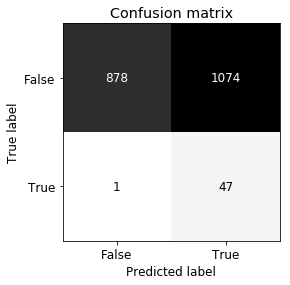

In [517]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(y_test, svm_4.predict(X_test_selected)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

### SHAP explaining predictions after under-sampling

In [434]:
def shap_explain(X_train_selected, X_test_selected, clf, samples):
    explainer = shap.KernelExplainer(clf.predict_proba, X_train_selected)
    shap_values = explainer.shap_values(X_test_selected.loc[samples.index])
    return shap_values

In [445]:
samples_true = y_test[le.transform(y_test)==1]
samples = y_test.sample(samples_true.count(), random_state=0)
samples_all = pd.concat((pd.DataFrame(samples_true), pd.DataFrame(samples)))

In [446]:
shap_values_rf_1 = shap_explain(X_train_selected, X_test_selected, rf_1, samples_all)

100%|██████████| 96/96 [21:11<00:00, 13.25s/it]


In [449]:
shap_values_rf_2 = shap_explain(X_train_selected, X_test_selected, rf_2, samples_all)

100%|██████████| 96/96 [21:23<00:00, 13.37s/it]


In [467]:
shap_values_rf_3 = shap_explain(X_train_selected, X_test_selected, rf_3, samples_all)

100%|██████████| 96/96 [42:27<00:00, 26.54s/it]  


In [468]:
shap_values_svm_1 = shap_explain(X_train_selected, X_test_selected, svm_1, samples_all)

100%|██████████| 96/96 [36:14<00:00, 22.65s/it]


In [469]:
shap_values_svm_2 = shap_explain(X_train_selected, X_test_selected, svm_2, samples_all)

100%|██████████| 96/96 [34:19<00:00, 21.45s/it]


In [470]:
shap_values_svm_3 = shap_explain(X_train_selected, X_test_selected, svm_3, samples_all)

100%|██████████| 96/96 [25:16<00:00, 15.79s/it]


In [479]:
shap_values_svm_4 = shap_explain(X_train_selected, X_test_selected, svm_4, samples_all)

100%|██████████| 96/96 [28:57<00:00, 18.10s/it]


In [229]:
shap.initjs()

In [567]:
i = 49
shap.force_plot(shap_values_rf_3[1][i], X_test_selected.loc[samples_all.index].iloc[i, :])

In [568]:
rf_3.predict_proba([X_test_selected.loc[samples_all.index].iloc[i, :]])

array([[ 0.5,  0.5]])

In [570]:
shap.force_plot(shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

### SHAP explanation of SVM with Random undersampling

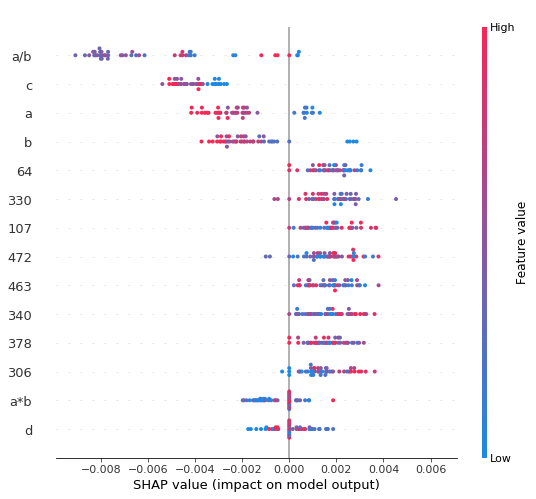

In [577]:
shap.summary_plot(shap_values_svm_4[1][0:47,:], X_test_selected.loc[samples_all.index].iloc[0:47,:])

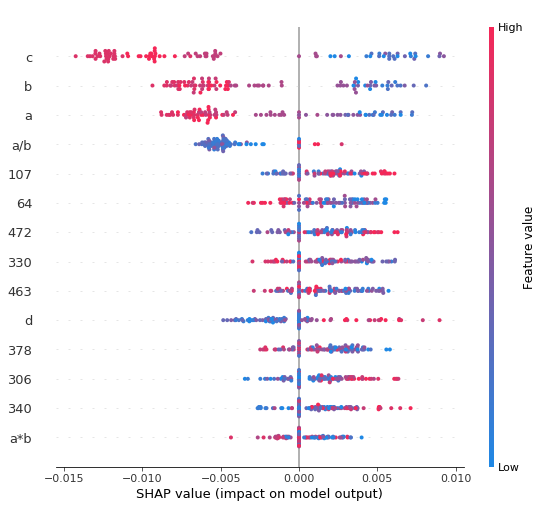

In [471]:
shap.summary_plot(shap_values_svm_1[1], X_test_selected.loc[samples_all.index])

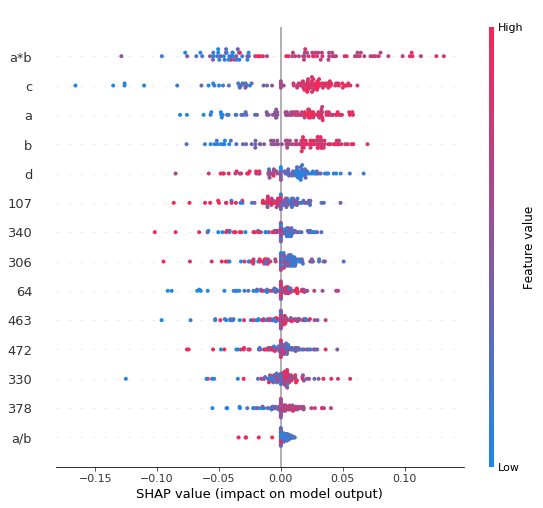

In [472]:
shap.summary_plot(shap_values_svm_2[1], X_test_selected.loc[samples_all.index])

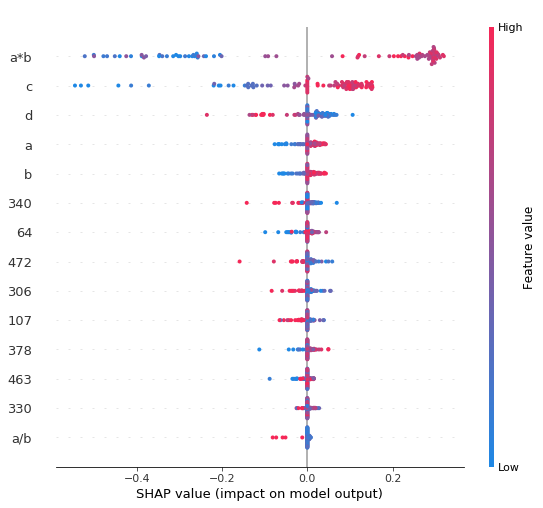

In [473]:
shap.summary_plot(shap_values_svm_3[1], X_test_selected.loc[samples_all.index])

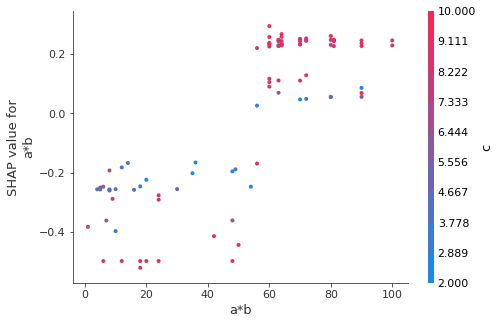

In [452]:
shap.dependence_plot("a*b", shap_values_rf_1[1], X_test_selected.loc[samples_all.index])

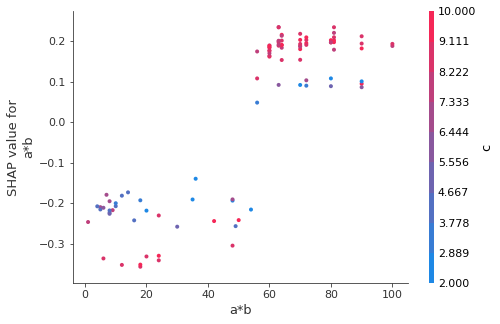

In [560]:
shap.dependence_plot("a*b", shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

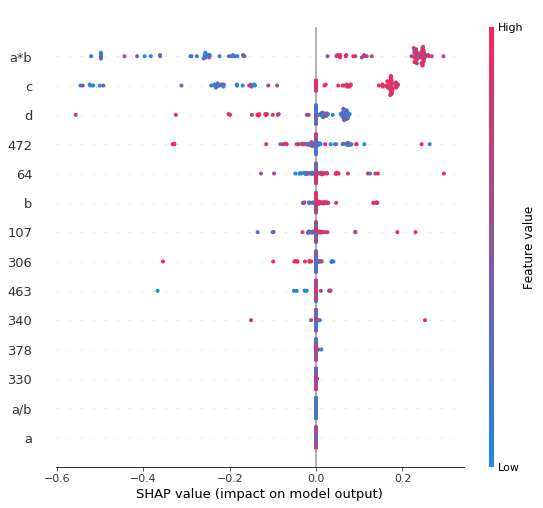

In [499]:
shap.summary_plot(shap_values_rf_1[1], X_test_selected.loc[samples_all.index])

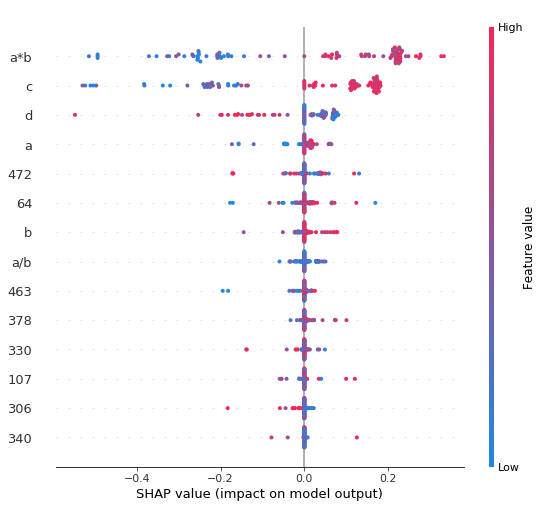

In [500]:
shap.summary_plot(shap_values_rf_2[1], X_test_selected.loc[samples_all.index])

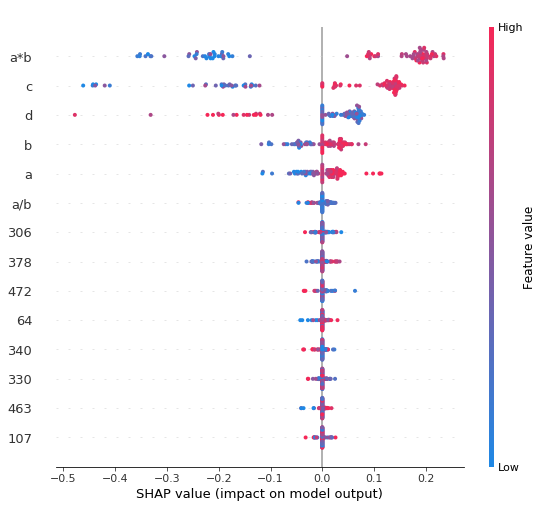

In [501]:
shap.summary_plot(shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

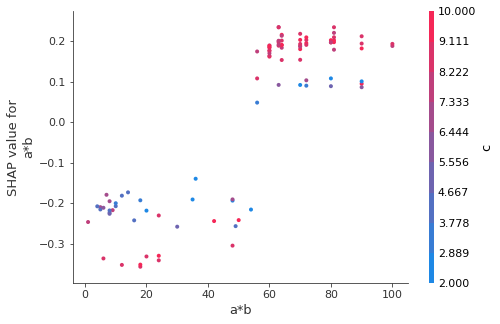

In [521]:
shap.dependence_plot("a*b", shap_values_rf_3[1], X_test_selected.loc[samples_all.index])

### SHAP explanation of Random Forests with Random undersampling

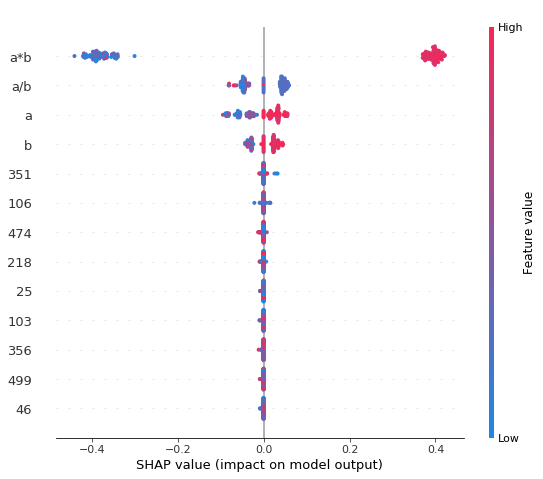

In [245]:
shap.summary_plot(shap_values_rf[1], pd.DataFrame(X_test_selected))

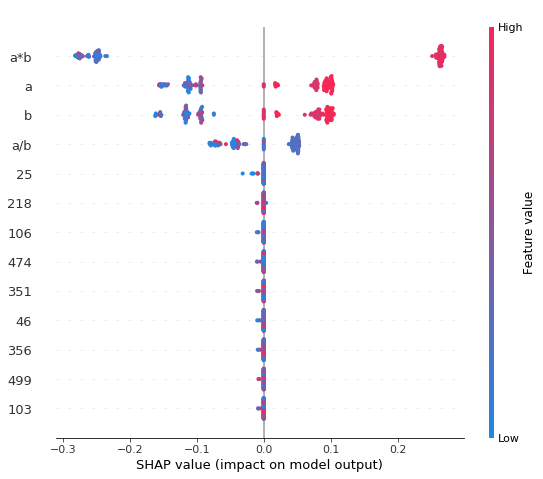

In [213]:
shap.summary_plot(shap_values_rf_500[1], pd.DataFrame(X_test_selected))

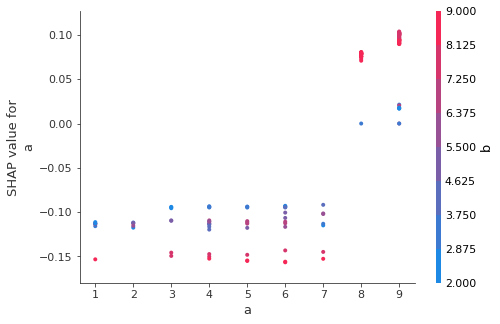

In [267]:
shap.dependence_plot("a", shap_values_rf_500[1], X_test_selected)

### SHAP explaining predictions of XGBoost

In [483]:
xgb_train = xgboost.DMatrix(X_train_selected, label=le.transform(y_train_sampled))
xgb_test = xgboost.DMatrix(X_test_selected, label=le.transform(y_test))

In [563]:
# use validation set to choose # of trees
params = {'max_depth':20, 'n_estimators':5,
         'objective': 'multi:softmax', 'num_class': 2
}

xgb = xgboost.train(params, xgb_train, 100)

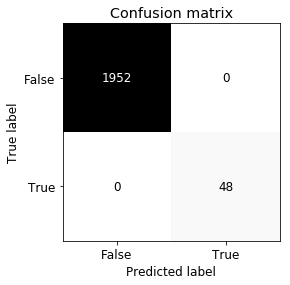

In [564]:
target_names = np.array(le.classes_)
scores_image = mglearn.tools.heatmap(
    confusion_matrix(le.transform(y_test), xgb.predict(xgb_test)), xlabel='Predicted label',
    ylabel='True label', xticklabels=target_names,
    yticklabels=target_names, cmap=plt.cm.gray_r, fmt="%d")    
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

In [565]:
shap_values_xgb = xgb.predict(xgb_test, pred_contribs=True)

In [578]:
shap.force_plot(shap_values_xgb[:, 1, :], X_test_selected)

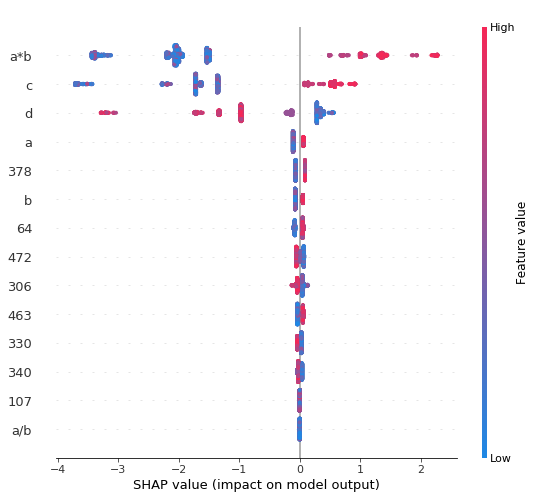

In [566]:
shap.summary_plot(shap_values_xgb[:, 1, :], X_test_selected)

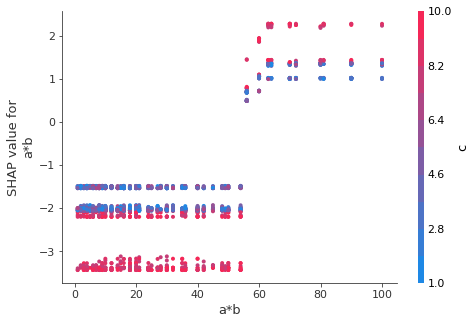

In [488]:
shap.dependence_plot("a*b", shap_values_xgb[:, 1, :], X_test_selected)

In [522]:
shap_interaction_values = xgb.predict(xgb_test, pred_interactions=True)

In [523]:
X_test_selected.columns = X_test_selected.columns.astype(str)

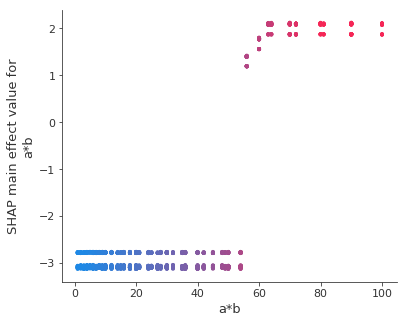

In [526]:
shap.dependence_plot(
    ("a*b", "a*b"),
    shap_interaction_values[:, 1, :, :], X_test_selected,
    display_features=X_test_selected
)

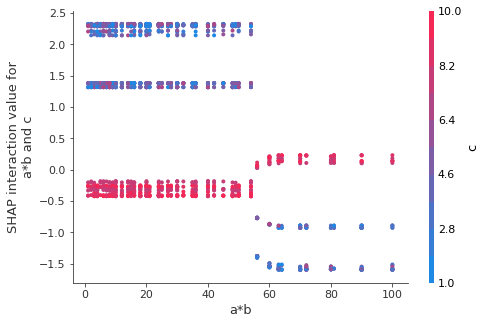

In [562]:
shap.dependence_plot(
    ("a*b", "c"),
    shap_interaction_values[:, 1, :, :], X_test_selected,
    display_features=X_test_selected
)